# Cyberbullying Filter

In [1]:
import pandas as pd
import os
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt

import string
import nltk
from nltk import word_tokenize          
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

import emoji
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier

from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.metrics import classification_report,accuracy_score

## Preparing The Data

_data.csv_ is the labelled cyberbully data from http://research.cs.wisc.edu/bullying/data.html

_tweets.csv_ is the raw tweet data from twitter.com.

In [2]:
tweet = pd.read_csv("tweet.csv")
data  = pd.read_csv("data.csv")
print("The number of tweets in tweet.csv is ", tweet.tweet_id.nunique())
print("The number of tweets in data.csv is ", data.tweet_id.nunique())

allTweets = pd.merge(tweet, data, on='tweet_id')
print("The number of merged tweets (training set) is ", allTweets.tweet_id.nunique())

allTweets = allTweets[['tweet_id','tweet','flag']]
bullyTweets = allTweets.loc[allTweets["flag"] == "y"] 
noBullyTweets = allTweets.loc[allTweets["flag"] == "n"] 
print("The total number of tweets is ", allTweets.tweet_id.nunique())
print("The number of bully flag tweets (flag == y) is ", bullyTweets.tweet_id.nunique())
print("The number of non bullying tweets (flag == n) is ", noBullyTweets.tweet_id.nunique())

The number of tweets in tweet.csv is  2729
The number of tweets in data.csv is  7298
The number of merged tweets (training set) is  2729
The total number of tweets is  2729
The number of bully flag tweets (flag == y) is  1109
The number of non bullying tweets (flag == n) is  1622


### A Quick Sample of the Data:

In [3]:
pd.options.display.max_rows
pd.set_option('display.max_colwidth', -1)
bullyTweets.head(20)

,tweet_id,tweet,flag
0,108765481514708992,"@Underwalt @MsShandraRae @kateplusmy8 mr. walt, stop being a bully.",y
2,100335301150507008,@katie_ogden @boybandslut @StephWall27 @BAMitsSHAZ @xstephhh_ I was not bullying her! She's trying to steal Jean Martyn from meee! :'( xx,y
3,107852102461693953,"This is actually bullying , I want Wenger to watch this and fucking hold every piece of criticism that comes ! #RAGE",y
5,103925126613045250,@JJS1994_ stop bullying me,y
9,104028556509716480,@TrickyStewart Hey!(: We Are Beliebers!(: Can YouTell BIEBER To Tweet Us!(: My Friend Has Been Bullied And Needs Cheered Up!XD,y
10,101324602789208064,don't you get it? This is me getting rid of you. Hahaha #BULLY,y
14,108340745324335104,Damm I think I'm slick bully this dude always offering shit to avoid me for roasting his ass LoL,y
20,102903555840675840,@chelseabieber95 duuuuude. cyber bully much? I just read some of the tweets. how did it even start,y
27,108042149437779970,"i SWEAR I HAVE THE SWEETEST BOO IN THE WORLD, WHEN WE NOT BULLYING ME &lt;3",y
28,102533497637437441,For those keeping score at home- cousin who just had massive heart-attack is trying to bully the doctors into letting her out one day early.,y


In [4]:
noBullyTweets.head(20)

,tweet_id,tweet,flag
1,100254756332769280,"Paula, Kiersten and LJ's song about bullying. Great job! (Uploading more videos now.) http://fb.me/ASIm1gw1",n
4,106150056868061184,"If I'm not happy with my classes this week, I'm gonna take the role as a bully and be an asshole. Watch out lower-classmen. It will be ugly.",n
6,104199536133668864,"@ninjacodemonkey totally. on one hand the retaliatory nature is pissy, on the other is great to see that bully-stick smackdown.",n
7,103471384973418497,"@lucy_robbo yes on thur, she said she might, we'll bully in revs. I dunno I have no friends hahaha",n
8,101884602586636288,"theres going to be bullys and ignorant people out there thats goi to spread lies about u or bully u,well DONT let it get u down",n
11,102779484725448704,The Bully at School Goes High Tech – Part 1: \nThe Section of State and Local Government Law of the Am... http://t.co/DGWXoKd #slaw #law,n
12,104826899435491328,Follow-Up to ' Signs Your Child Might Be Getting Bullied' #moms #dads http://t.co/vsfXkHD #parenting #kids,n
13,100689407677440000,"WED at 8pm on #LETITBEKNOWNLIVERADIO our Discussion ""Violence among the YOUTH PT 2..... Bullying, Gang Violenc… (cont) http://deck.ly/~ZN88q",n
15,103502694634889216,@BillyBlancO_ @DjLBully nigga used to be a real herbalist bully idk wham ah deal with,n
16,104295456787533824,Georgetown got there asses kicked but china.. Bull got cleaned up with a chair,n


## Dictionary Creation
Creates a function that uses  alist and empty dictionary to return a dictionary of all the words and their frequencies from the tweets, sorted by their frequencies.

In [5]:
# supporting functions

def tokenize(text):
    tokens = [i.strip() for i in text if i not in string.punctuation if i not in emoji.UNICODE_EMOJI]
    return "".join(tokens)

stopwordSet = set(stopwords.words("english"))
def word_filter(word):
    # strip
    word = word.strip().lower()
    word = tokenize(word.strip(string.punctuation))
    if word == "":
        return False, None
    # get rid of mentions (@USERNAME)
    if word[0] == "@":
        return False, None
    
    # get rid of stopwords
    elif (word in stopwordSet):
        return False, None
    
    # get rid of emojis
    elif word in emoji.UNICODE_EMOJI:
        return False, None
    return True, word

word_filter("'it'")

(False, None)

~~~

In [6]:
def dictionary_creation(tweetLst, bullyVocab):
    for tweet in tweetLst:
        for word in tweet.split():
            flag, resultWord = word_filter(word)

            if flag:
                if(resultWord == "it"):
                    print(flag, resultWord)
                # check if in bullyVocab
                if resultWord in bullyVocab:
                    bullyVocab[resultWord] += 1
                else:
                    bullyVocab[resultWord] = 1
    bullyVocab = sorted(bullyVocab.items(), key = lambda kv: kv[1], reverse = True)
    return bullyVocab

In [7]:
def bar_graph(bullyVocab, number):
    # create a bar graph of the bullyVocab data
    words = [i[0] for i in bullyVocab if not i[0] == ""]
    topNWords = words[:number]

    y_pos = np.arange(len(topNWords))
    frequency = [i[1] for i in bullyVocab if not i[0] == ""]
    topNFrequency = frequency[:number]
    
    plt.figure(figsize = (15, 7))

    plt.bar(y_pos, topNFrequency, align = 'center')
    plt.xticks(y_pos, topNWords)
    plt.xticks(rotation = 50)
    plt.xlabel("Word")
    plt.ylabel("Frequency")
    plt.show()

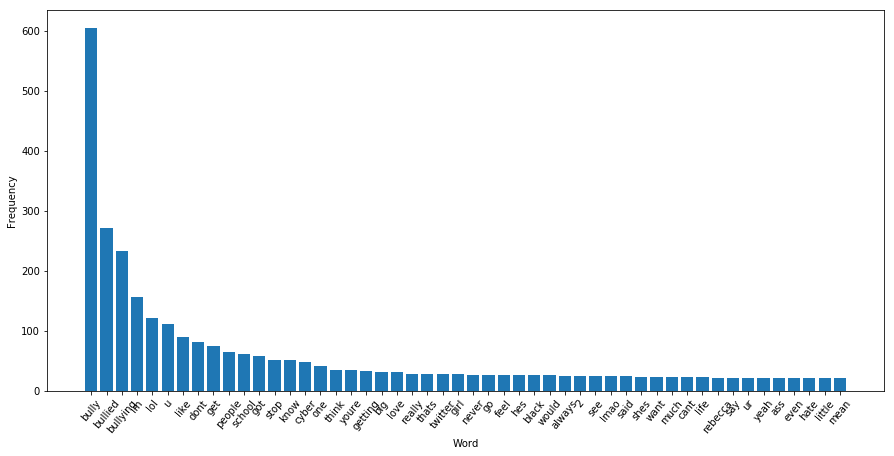

In [8]:
bullyTweetLst = bullyTweets["tweet"].tolist()

bullyVocab = {}
dictionary_creation(bullyTweetLst, bullyVocab)

# sort the dictionary by the words with the highest frequency                
bullyVocab = sorted(bullyVocab.items(), key = lambda kv: kv[1], reverse = True)

bar_graph(bullyVocab, 50)

## Word Clouds

Generating wordclouds based on frequencies!

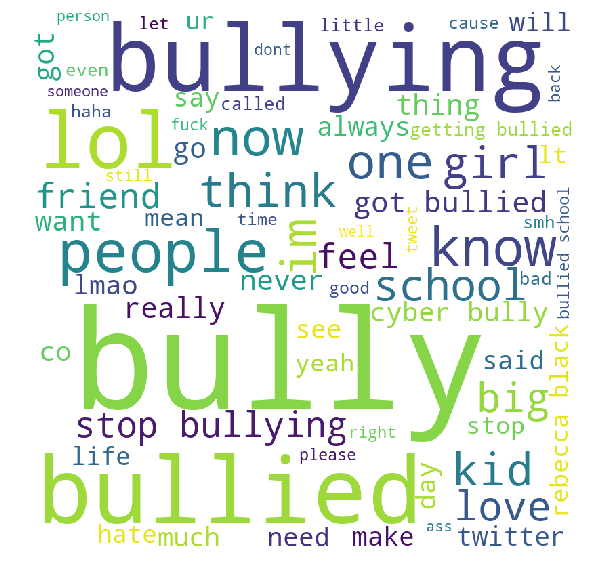

In [9]:
comment_words = " "
comment_words2 = " "

def generate_wordcloud(tweets, comment_words, fontsize):
    for val in tweets.tweet:
        val = str(val)
        words = val.split()
        for i in range(len(words)):
            words[i] = words[i].lower()
            
        for word in words:
            comment_words = comment_words + word + " "
            
    # actual cloud
    wordcloud = WordCloud(width = 800, height = 800, background_color = 'white',
                          stopwords = set(STOPWORDS), min_font_size = fontsize).generate(comment_words)

    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0.5)
    plt.show()

generate_wordcloud(bullyTweets, comment_words, 20)

# generate_wordcloud(noBullyTweets, comment_words2, 20)

In [10]:
def img_wordcloud(tweets, image, comment_words):
    mask = np.array(open(image))
    wordcloud = Wordcloud(stopwords = stopwords, background_color = "white", mode = "RGBA",
                         max_words = 1000, mask = mask).generate(tweets)
    
    # colors
    image_colors = ImageColorGenerator(mask)
    plt.figure(figsize = [8, 8])
    plt.imshow(wordcloud_usa.recolor(color_func=image_colors), interpolation = "bilinear")
    plt.axis("off")
    
    plt.show()
    
#img_wordcloud(bullyTweets, "![image.png](attachment:image.png)", comment_words)


In [11]:
input_data = allTweets
label_data = allTweets['flag'] 
target = np.array(label_data)

type(input_data)

pandas.core.frame.DataFrame

In [20]:
indices = np.random.permutation(allTweets.shape[0])

In [21]:
ninety = int(.9 * len(indices))
training_idx, test_idx = indices[:ninety], indices[ninety:]

training, test = input_data.loc[training_idx,"tweet":"flag"], input_data.loc[test_idx,"tweet":"flag"]

training_data = training['tweet'].tolist()
training_label= training['flag']

test_data = test['tweet'].tolist()
test_label= test['flag'].tolist()

In [22]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(training_data)
X_train_counts.shape

from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

(2469, 7729)

In [23]:
# Performance of NB Classifier

from sklearn.naive_bayes import MultinomialNB

text_clf = Pipeline([('vect', CountVectorizer(ngram_range=(1, 2))), ('tfidf', TfidfTransformer(use_idf=False)), ('clf', MultinomialNB(alpha=1e-2))])
text_clf = text_clf.fit(training_data, training_label)
# Performance of NB Classifier
predicted = text_clf.predict(test_data)
print(np.mean(predicted == test_label))
print (classification_report(test_label, predicted))

0.7636363636363637
              precision    recall  f1-score   support

           n       0.82      0.79      0.81       170
           y       0.68      0.71      0.70       105

   micro avg       0.76      0.76      0.76       275
   macro avg       0.75      0.75      0.75       275
weighted avg       0.77      0.76      0.76       275



In [24]:
# Support Vector Machine (SVM) Classifier   
text_clf_svm = Pipeline([('vect', CountVectorizer(ngram_range=(1, 2))), ('tfidf', TfidfTransformer(use_idf= True)),
                         ('clf-svm', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, max_iter=1000, tol = 0.19, random_state=42))])

text_clf_svm = text_clf_svm.fit(training_data, training_label)
predicted_svm = text_clf_svm.predict(test_data)
np.mean(predicted_svm == test_label)

from sklearn.metrics import accuracy_score, precision_score, classification_report, confusion_matrix
print ("Accuracy:", accuracy_score(test_label, predicted_svm))
print (classification_report(test_label, predicted_svm))

Accuracy: 0.7854545454545454
              precision    recall  f1-score   support

           n       0.81      0.85      0.83       170
           y       0.74      0.68      0.71       105

   micro avg       0.79      0.79      0.79       275
   macro avg       0.77      0.76      0.77       275
weighted avg       0.78      0.79      0.78       275



In [26]:
#Logistic Regression ) Classifier 
text_lr = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), ('lr', LogisticRegression())])
text_lr = text_lr.fit(training_data, training_label)
# Performance of NB Classifier
predicted = text_lr.predict(test_data)
np.mean(predicted == test_label)
print ("Accuracy:", accuracy_score(test_label, predicted))
print (classification_report(test_label, predicted))

Accuracy: 0.8
              precision    recall  f1-score   support

           n       0.83      0.85      0.84       170
           y       0.75      0.72      0.73       105

   micro avg       0.80      0.80      0.80       275
   macro avg       0.79      0.79      0.79       275
weighted avg       0.80      0.80      0.80       275



In [19]:
indices = np.random.permutation(allTweets.shape[0])
startIndex = int(.50 * len(indices))

timeSVMList = []
timeNBList = []
timeLRList = []
sizeList = []

import time
for endIndex in range (startIndex + 50, len(indices), 50):
    test_idx = indices[startIndex:endIndex]
    test = input_data.loc[test_idx,"tweet":"flag"]
    test_data = test['tweet'].tolist()
    test_label= test['flag'].tolist()
    
    start = time.time()
    predicted_svm = text_clf_svm.predict(test_data)
    used = time.time() - start
    timeSVMList.append(used)
    
    start = time.time()
    predicted_svm = text_clf.predict(test_data)
    used = time.time() - start
    timeNBList.append(used)    
    
    start = time.time()
    predicted_svm = text_lr.predict(test_data)
    used = time.time() - start
    timeLRList.append(used)    
    
    size = endIndex - startIndex
    sizeList.append(size)

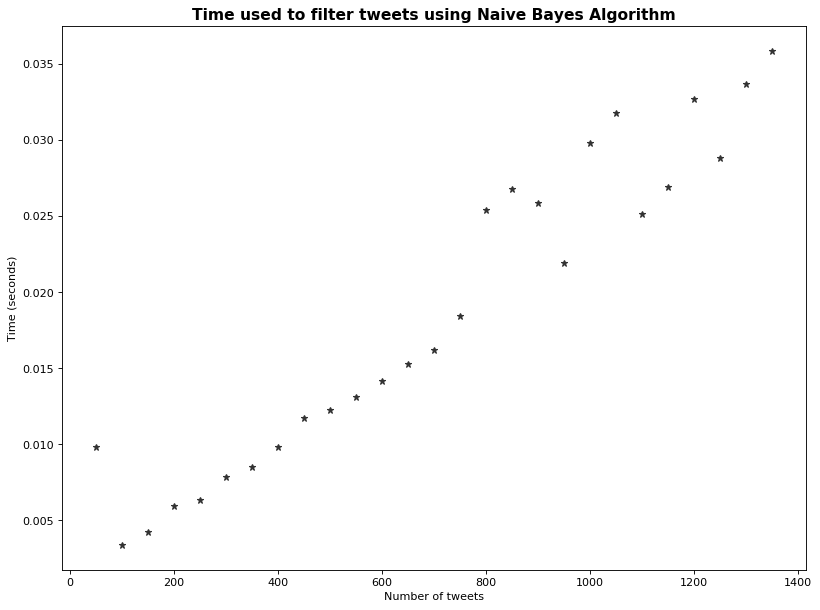

In [24]:
figure(num=None, figsize=(12, 9), dpi=80, facecolor='w', edgecolor='k')
plt.plot(sizeList, timeNBList, '*', color="#333333", label="Naive Bayes")
plt.title("Time used to filter tweets using Naive Bayes Algorithm", fontsize=14, fontweight='bold')
plt.xlabel("Number of tweets")
plt.ylabel("Time (seconds)")
plt.show()

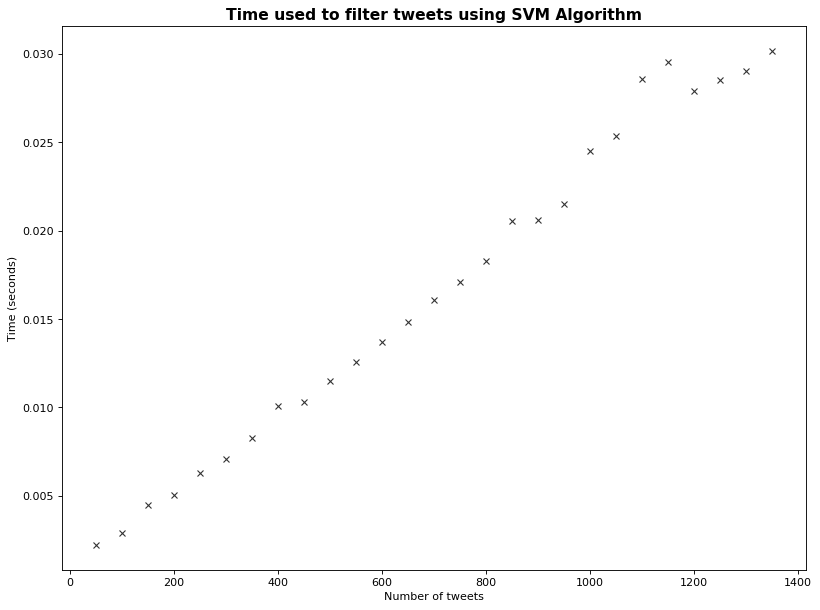

In [27]:
figure(num=None, figsize=(12, 9), dpi=80, facecolor='w', edgecolor='k')
plt.plot(sizeList, timeSVMList, 'x', color="#333333", label="SVM")
plt.title("Time used to filter tweets using SVM Algorithm", fontsize=14, fontweight='bold')
plt.xlabel("Number of tweets")
plt.ylabel("Time (seconds)")
plt.show()

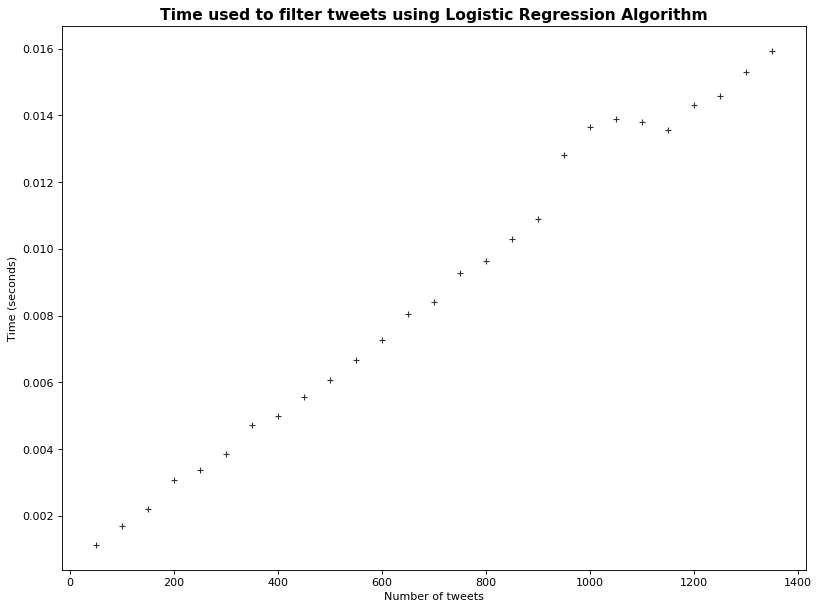

In [28]:
figure(num=None, figsize=(12, 9), dpi=80, facecolor='w', edgecolor='k')
plt.plot(sizeList, timeLRList, '+', color="#333333", label="LR")
plt.title("Time used to filter tweets using Logistic Regression Algorithm", fontsize=14, fontweight='bold')
plt.xlabel("Number of tweets")
plt.ylabel("Time (seconds)")
plt.show()

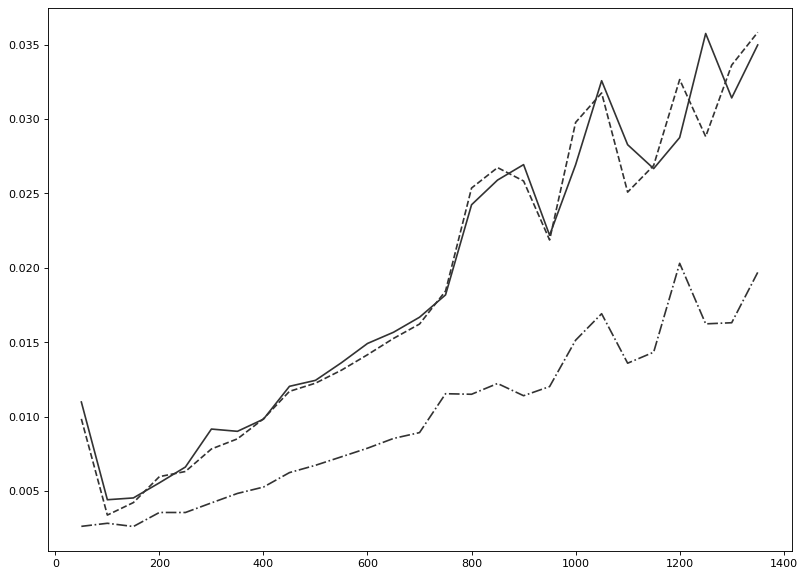

In [89]:
figure(num=None, figsize=(12, 9), dpi=80, facecolor='w', edgecolor='k')

plt.plot(sizeList, timeNBList, '--', color="#333333", label="Naive Bayes")

plt.plot(sizeList, timeLRList, '-.', color="#333333", label="LR")

plt.plot(sizeList, timeSVMList, '-', color="#333333", label="SVM")

plt.xlabel("T")
plt.show()